In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [139]:
# Import data from the listed url
train = np.loadtxt(np.DataSource().open('http://www.amlbook.com/data/zip/features.train'), dtype=float)
test = np.loadtxt(np.DataSource().open('http://www.amlbook.com/data/zip/features.test'), dtype=float)

In [140]:
def transform(x):
    phi = np.ones([x.shape[0], 6])
    phi[:, 1:3] = x[:, 1:]
    phi[:, 3] = x[:, 1]*x[:, 2]
    phi[:, 4:] = x[:, 1:]**2
    return phi

In [141]:
def classify_points(Z_data, w_guess):
    return np.sign(np.dot(Z_data, w_guess))

In [142]:
def one_vs_all(num, y):
    # Reclassifies the data using a one versus all scheme
    new_y = np.empty_like(y)
    new_y[y != num] = -1
    new_y[y == num] = 1
    return new_y

In [143]:
def one_vs_one(num1, num2, X, y):
    # Reclassifies the data using a one versus one scheme
    new_X = np.copy(X[y == num1])
    new_X = np.vstack((new_X, X[y == num2]))
    new_y = -np.ones_like(y[y == num1])
    new_y = np.append(new_y, np.ones_like(y[y == num2]))
    return new_X, new_y

In [144]:
def run_linear_regression(X_in, y_in, X_out, y_out, transform=lambda x: x, weight_decay=False, lam=None):
    # Apply the nonlinear transformation to the data
    Z_in, Z_out = transform(X_in), transform(X_out)
    
    # Find the least squares solution w to Z*w = y
    if weight_decay:
        A = np.dot(Z_in.T, Z_in) + lam*np.eye(Z_in.shape[1])
        b = np.dot(Z_in.T, y_in)
        w = np.linalg.solve(A, b)
    else:
        w = np.linalg.lstsq(Z_in, y_in)[0]
    
    # Classify points based on w
    y_in_guess, y_out_guess = classify_points(Z_in, w), classify_points(Z_out, w)
    
    # Calculate the error
    error_in = np.mean(y_in_guess != y_in)
    error_out = np.mean(y_out_guess != y_out)
    return w, error_in, error_out

In [145]:
def postal_experiment(num, X_in, y_in, X_out, y_out):
    y_in_mod, y_out_mod = one_vs_all(num, y_in), one_vs_all(num, y_out)
    wlin, e_in_lin, e_out_lin = run_linear_regression(X_in, y_in_mod, X_out, y_out_mod, weight_decay=True, lam=1)
    wquad, e_in_quad, e_out_quad = run_linear_regression(X_in, y_in_mod, X_out, y_out_mod, transform=transform, 
                                                   weight_decay=True, lam=1)
    return wlin, e_in_lin, e_out_lin, wquad, e_in_quad, e_out_quad

In [146]:
X_in, X_out = np.ones(shape=(train.shape[0], train.shape[1])), np.ones(shape=(test.shape[0], test.shape[1]))
X_in[:, 1:], y_in = train[:, 1:], train[:, 0]
X_out[:, 1:], y_out = test[:, 1:], test[:, 0]

In [147]:
e_in_lin, e_out_lin, e_in_quad, e_out_quad = (np.empty(10), )*4
for i in range(10):
    _, e_in_lin[i], e_out_lin[i], _, e_in_quad[i], e_out_quad[i] = postal_experiment(i, X_in, y_in, X_out, y_out)
print(' i   |   e_in_lin   |   e_out_lin   |   e_in_quad   |   e_out_quad   ')
print('--------------------------------------------------------------------')
format_str = ' %d   |   %.6f   |   %.7f   |   %.7f   |   %.8f   '
for i in range(10):
    print(format_str % (i, e_in_lin[i], e_out_lin[i], e_in_quad[i], e_out_quad[i]))

 i   |   e_in_lin   |   e_out_lin   |   e_in_quad   |   e_out_quad   
--------------------------------------------------------------------
 0   |   0.106627   |   0.1066268   |   0.1066268   |   0.10662681   
 1   |   0.021923   |   0.0219233   |   0.0219233   |   0.02192327   
 2   |   0.098655   |   0.0986547   |   0.0986547   |   0.09865471   
 3   |   0.082711   |   0.0827105   |   0.0827105   |   0.08271051   
 4   |   0.099651   |   0.0996512   |   0.0996512   |   0.09965122   
 5   |   0.079223   |   0.0792227   |   0.0792227   |   0.07922272   
 6   |   0.084704   |   0.0847035   |   0.0847035   |   0.08470354   
 7   |   0.073244   |   0.0732436   |   0.0732436   |   0.07324365   
 8   |   0.082711   |   0.0827105   |   0.0827105   |   0.08271051   
 9   |   0.088191   |   0.0881913   |   0.0881913   |   0.08819133   


In [148]:
new_X, new_y = one_vs_one(1, 5, X_in, y_in)
X_out1, y_out1 = one_vs_one(1, 5, X_out, y_out)
w, e_in, e_out = run_linear_regression(new_X, new_y, X_out1, y_out1, transform=transform, 
                                       weight_decay=True, lam=1)
print(e_in, e_out)

0.00512491992313 0.0259433962264


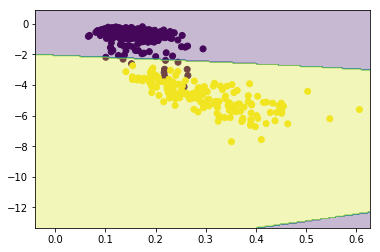

In [149]:
x1min, x1max = new_X[:, 1].min() - 0.1, new_X[:, 1].max() + 0.1
x2min, x2max = new_X[:, 2].min() - 6, new_X[:, 2].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max, 200))
X_plotting = np.c_[np.ones(xx1.size), xx1.ravel(), xx2.ravel()]
plt.scatter(X_out1[:, 1], X_out1[:, 2], c=y_out1)
plt.contourf(xx1, xx2, np.sign(np.dot(transform(X_plotting), w)).reshape(xx1.shape), alpha=0.3)
plt.show()

In [150]:
x1min, x1max = X_in[:, 1].min() - 0.1, X_in[:, 1].max() + 0.1
x2min, x2max = X_in[:, 2].min() - 6, X_in[:, 2].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max, 200))
X_plotting = np.c_[np.ones(xx1.size), xx1.ravel(), xx2.ravel()]

In [151]:
svx = np.array([1, 0, 0, 1, 0, -1, -1, 0, 0, 2, 0, -2, -2, 0])
svx = np.reshape(svx, (7, 2))
svy = np.array([-1, -1, -1, 1, 1, 1, 1])
print(svx)

[[ 1  0]
 [ 0  1]
 [ 0 -1]
 [-1  0]
 [ 0  2]
 [ 0 -2]
 [-2  0]]


In [152]:
def svtransform(x):
    z = np.empty_like(x.T)
    z[0] = x.T[1]**2 - 2*x.T[0] - 1
    z[1] = x.T[0]**2 - 2*x.T[1] + 1
    return z.T

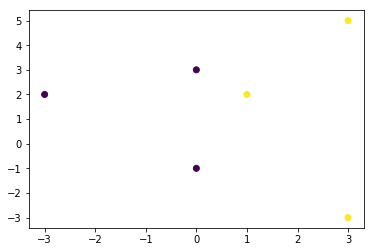

In [153]:
svz = svtransform(svx)[:-1]
plt.scatter(svz[:, 0], svz[:, 1], c=svy[:-1])
plt.show()

In [154]:
clf = SVC(C=np.inf, kernel='poly', degree=2, coef0 = 1, max_iter=10**5)
clf.fit(svx, svy)

SVC(C=inf, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=100000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

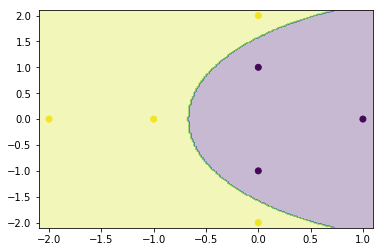

In [155]:
x1min, x1max = svx[:, 0].min() - 0.1, svx[:, 0].max() + 0.1
x2min, x2max = svx[:, 1].min() - 0.1, svx[:, 1].max() + 0.1
xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max, 200))
X_plotting = np.c_[xx1.ravel(), xx2.ravel()]
plt.scatter(svx[:, 0], svx[:, 1], c=svy)
plt.contourf(xx1, xx2, clf.predict(X_plotting).reshape(xx1.shape), alpha=0.3)
plt.show()

In [82]:
print(clf.n_support_)
print(clf.support_)

[2 3]
[1 2 3 4 5]


In [118]:
def target_function(x):
    return np.sign(x[:, 1] - x[:, 0] + np.sin(np.pi*x[:, 0])/4)

In [119]:
def generate_data(n_points):
    x = np.random.uniform(low=-1, high=1, size=(n_points, 2))
    y = target_function(x)
    return x, y

In [120]:
def cluster(X, mu):
    cluster_indices = np.empty(X.shape[0])
    for i in range(X.shape[0]):
        best_distance = np.inf
        best_index = mu.shape[0]
        for j in range(mu.shape[0]):
            if np.linalg.norm(X[i] - mu[j]) < best_distance:
                best_index = j
                best_distance = np.linalg.norm(X[i] - mu[j])
        cluster_indices[i] = best_index
    return cluster_indices

In [121]:
def lloyd(X, k, mu=None):
    # Initialize centers randomly
    if mu == None:
        x1min, x2min = np.amin(X, axis=0)
        x1max, x2max = np.amax(X, axis=0)
        mu = np.empty(shape=(k, X.shape[1]))
        mu[:, 0] = np.random.uniform(low=x1min, high=x1max, size=k)
        mu[:, 1] = np.random.uniform(low=x2min, high=x2max, size=k)
    
    cluster_indices = cluster(X, mu)
    
    for j in range(k):
        if j not in cluster_indices:
            mu, cluster_indices = lloyd(X, k)
            return mu, cluster_indices
    
    iterate = True
    while iterate:
        for j in range(k):
            mu[j] = np.mean(X[cluster_indices == j], axis=0)
        
        new_cluster_indices = cluster(X, mu)
        
        for j in range(k):
            if j not in cluster_indices:
                # If one of the clusters is empty, start over
                mu, cluster_indices = lloyd(X, k)
                return mu, cluster_indices
        
        iterate = not np.all(new_cluster_indices == cluster_indices)
        cluster_indices = np.copy(new_cluster_indices)
    
    return mu, cluster_indices

In [131]:
def trial(gamma, N=100, K=9):
    x, y = generate_data(N)
    
    clf = SVC(C=np.inf, gamma=gamma, max_iter=10**5)
    clf.fit(x, y)
    svc_e_in = np.mean(clf.predict(x) != y)
    
    mu, cluster_indices = lloyd(x, K)
    
    phi = np.ones(shape=(N, K + 1))
    for i in range(N):
        for j in range(K):
            phi[i, j + 1] = np.exp(-gamma*np.linalg.norm(x[i] - mu[j])**2)
    w = np.linalg.lstsq(phi, y)[0]
    
    rbf_e_in_array = np.zeros(N)
    for i in range(N):
        h_sum = w[0]
        for j in range(K):
            h_sum += w[j + 1]*np.exp(-gamma*np.linalg.norm(x[i] - mu[j])**2)
        rbf_e_in_array[i] = np.abs(np.sign(h_sum) - y[i])
    rbf_e_in = np.mean(rbf_e_in_array)
    
    x_out, y_out = generate_data(10**2)
    svc_e_out = np.mean(clf.predict(x_out) != y_out)
    
    rbf_e_out_array = np.zeros(10**2)
    for i in range(10**2):
        h_sum = w[0]
        for j in range(K):
            h_sum += w[j + 1]*np.exp(-gamma*np.linalg.norm(x_out[i] - mu[j])**2)
        rbf_e_out_array[i] = np.abs(np.sign(h_sum) - y_out[i])
    rbf_e_out = np.mean(rbf_e_out_array)
    
    return svc_e_in, svc_e_out, rbf_e_in, rbf_e_out

In [132]:
def experiment(trials, gamma, N=100, K=9):
    svc_e_in, svc_e_out, rbf_e_in, rbf_e_out = (np.zeros(trials), )*4
    
    for i in range(trials):
        svc_e_in[i], svc_e_out[i], rbf_e_in[i], rbf_e_out[i] = trial(gamma, N, K)
    
    return svc_e_in, svc_e_out, rbf_e_in, rbf_e_out

In [135]:
svc_e_in, svc_e_out, rbf_e_in, rbf_e_out = experiment(100, gamma=1.5, N=100, K=9)

In [138]:
svc_e_in, svc_e_out, rbf_e_in, rbf_e_out

(array([ 0.04,  0.14,  0.02,  0.06,  0.12,  0.18,  0.02,  0.22,  0.22,  0.08]),
 array([ 0.04,  0.14,  0.02,  0.06,  0.12,  0.18,  0.02,  0.22,  0.22,  0.08]),
 array([ 0.04,  0.14,  0.02,  0.06,  0.12,  0.18,  0.02,  0.22,  0.22,  0.08]),
 array([ 0.04,  0.14,  0.02,  0.06,  0.12,  0.18,  0.02,  0.22,  0.22,  0.08]))

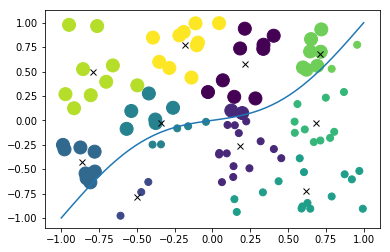

In [62]:
x_plotting = np.linspace(-1, 1)
x, y = generate_data(100)
mu, cluster_indices = lloyd(x, 10)
areas = (10 + 3*y)**2
plt.scatter(x[:, 0], x[:, 1], s=areas, c=cluster_indices)
plt.plot(mu[:, 0], mu[:, 1], 'kx')
plt.plot(x_plotting, x_plotting - np.sin(np.pi*x_plotting)/4)
plt.show()

In [86]:
clf = SVC(C=np.inf, gamma=1.5, max_iter=10**5)

In [87]:
clf.fit(x, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.5, kernel='rbf',
  max_iter=100000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
np.mean(clf.predict(x) != y)

0.0